In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings(action="ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

- X1 net profit / total assets
- X2 total liabilities / total assets
- X3 working capital / total assets
- X4 current assets / short-term liabilities
- X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- X6 retained earnings / total assets
- X7 EBIT / total assets
- X8 book value of equity / total liabilities
- X9 sales / total assets
- X10 equity / total assets
- X11 (gross profit + extraordinary items + financial expenses) / total assets
- X12 gross profit / short-term liabilities
- X13 (gross profit + depreciation) / sales
- X14 (gross profit + interest) / total assets
- X15 (total liabilities * 365) / (gross profit + depreciation)
- X16 (gross profit + depreciation) / total liabilities
- X17 total assets / total liabilities
- X18 gross profit / total assets
- X19 gross profit / sales
- X20 (inventory * 365) / sales
- X21 sales (n) / sales (n-1)
- X22 profit on operating activities / total assets
- X23 net profit / sales
- X24 gross profit (in 3 years) / total assets
- X25 (equity - share capital) / total assets
- X26 (net profit + depreciation) / total liabilities
- X27 profit on operating activities / financial expenses
- X28 working capital / fixed assets
- X29 logarithm of total assets
- X30 (total liabilities - cash) / sales
- X31 (gross profit + interest) / sales
- X32 (current liabilities * 365) / cost of products sold
- X33 operating expenses / short-term liabilities
- X34 operating expenses / total liabilities
- X35 profit on sales / total assets
- X36 total sales / total assets
- X37 (current assets - inventories) / long-term liabilities
- X38 constant capital / total assets
- X39 profit on sales / sales
- X40 (current assets - inventory - receivables) / short-term liabilities
- X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
- X42 profit on operating activities / sales
- X43 rotation receivables + inventory turnover in days
- X44 (receivables * 365) / sales
- X45 net profit / inventory
- X46 (current assets - inventory) / short-term liabilities
- X47 (inventory * 365) / cost of products sold
- X48 EBITDA (profit on operating activities - depreciation) / total assets
- X49 EBITDA (profit on operating activities - depreciation) / sales
- X50 current assets / total liabilities
- X51 short-term liabilities / total assets
- X52 (short-term liabilities * 365) / cost of products sold)
- X53 equity / fixed assets
- X54 constant capital / fixed assets
- X55 working capital
- X56 (sales - cost of products sold) / sales
- X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- X58 total costs /total sales
- X59 long-term liabilities / equity
- X60 sales / inventory
- X61 sales / receivables
- X62 (short-term liabilities *365) / sales
- X63 sales / short-term liabilities
- X64 sales / fixed assets
- Class - 0 didnot get bankrupt/ 1 - got bankrupt

In [9]:
one = pd.read_csv('Data/1year.csv')
two = pd.read_csv('Data/2year.csv')
three = pd.read_csv('Data/3year.csv')
four = pd.read_csv('Data/4year.csv')
five = pd.read_csv('Data/5year.csv')

In [10]:
one['bankrupt_after_years'] = 5
two['bankrupt_after_years'] = 4
three['bankrupt_after_years'] = 3
four['bankrupt_after_years'] = 2
five['bankrupt_after_years'] = 1

In [11]:
print(one.shape)
print(two.shape)
print(three.shape)
print(four.shape)
print(five.shape)

(7012, 66)
(10173, 66)
(10476, 66)
(9539, 66)
(5427, 66)


In [12]:
#Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #Add Dtype col
        l = []
        for i in mis_val_table.index:
            l.append(df[i].dtype)
        mis_val_table['dtype'] = l

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
def get_outliers_Zscore(data,threshold = 3, boxplot = False):
    outliers_index = []
    outliers_values = []
    Mean = np.mean(data)
    Std =np.std(data)
    
    for i, value in data.iteritems():
        z_score= (value - Mean)/Std 
        if np.abs(z_score) > threshold:
            outliers_index.append(i)
            outliers_values.append(value)
    if boxplot == True:
        plt.boxplot(data.dropna())
    return pd.DataFrame({'outliers_index':outliers_index,'outliers_values':outliers_values})

### Missing Values
- Missing values are entered as '?' and these columns are read as object dtype.
- There are 49 object columns and all of them have missing values.
- They are replaced with NaN.

In [14]:
object_type_cols = [col for col in one.columns.values if one[col].dtype == 'object']

In [15]:
len(object_type_cols)

49

In [16]:
i = 0
for col in object_type_cols:
    if '?' in one[col].values:
        i = i+1
print(i)

49


In [18]:
one.replace('?',np.NaN,inplace=True)
two.replace('?',np.NaN,inplace=True)
three.replace('?',np.NaN,inplace=True)
four.replace('?',np.NaN,inplace=True)
five.replace('?',np.NaN,inplace=True) 

In [19]:
object_type_cols = [col for col in one.columns.values if one[col].dtype == 'object']
for col in object_type_cols:
    one[col] = one[col].astype('float64')
    
object_type_cols = [col for col in two.columns.values if two[col].dtype == 'object']
for col in object_type_cols:
    two[col] = two[col].astype('float64')

object_type_cols = [col for col in three.columns.values if three[col].dtype == 'object']
for col in object_type_cols:
    three[col] = three[col].astype('float64')

object_type_cols = [col for col in four.columns.values if four[col].dtype == 'object']
for col in object_type_cols:
    four[col] = four[col].astype('float64')

object_type_cols = [col for col in five.columns.values if five[col].dtype == 'object']
for col in object_type_cols:
    five[col] = five[col].astype('float64')

In [20]:
data = pd.concat([one,two,three,four,five],ignore_index=True)

In [25]:
missing_values_table(data)

Your selected dataframe has 66 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values,dtype
Attr37,18643,43.7,float64
Attr21,5843,13.7,float64
Attr27,2718,6.4,float64
Attr60,2133,5.0,float64
Attr45,2128,5.0,float64
...,...,...,...
Attr35,8,0.0,float64
Attr1,8,0.0,float64
Attr57,7,0.0,float64
Attr59,7,0.0,float64


{'whiskers': [<matplotlib.lines.Line2D at 0x18de7071be0>,
 'caps': [<matplotlib.lines.Line2D at 0x18de708e6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18dea7e3e80>],
 'medians': [<matplotlib.lines.Line2D at 0x18ded0e6e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x18ded0ffeb8>],
 'means': []}

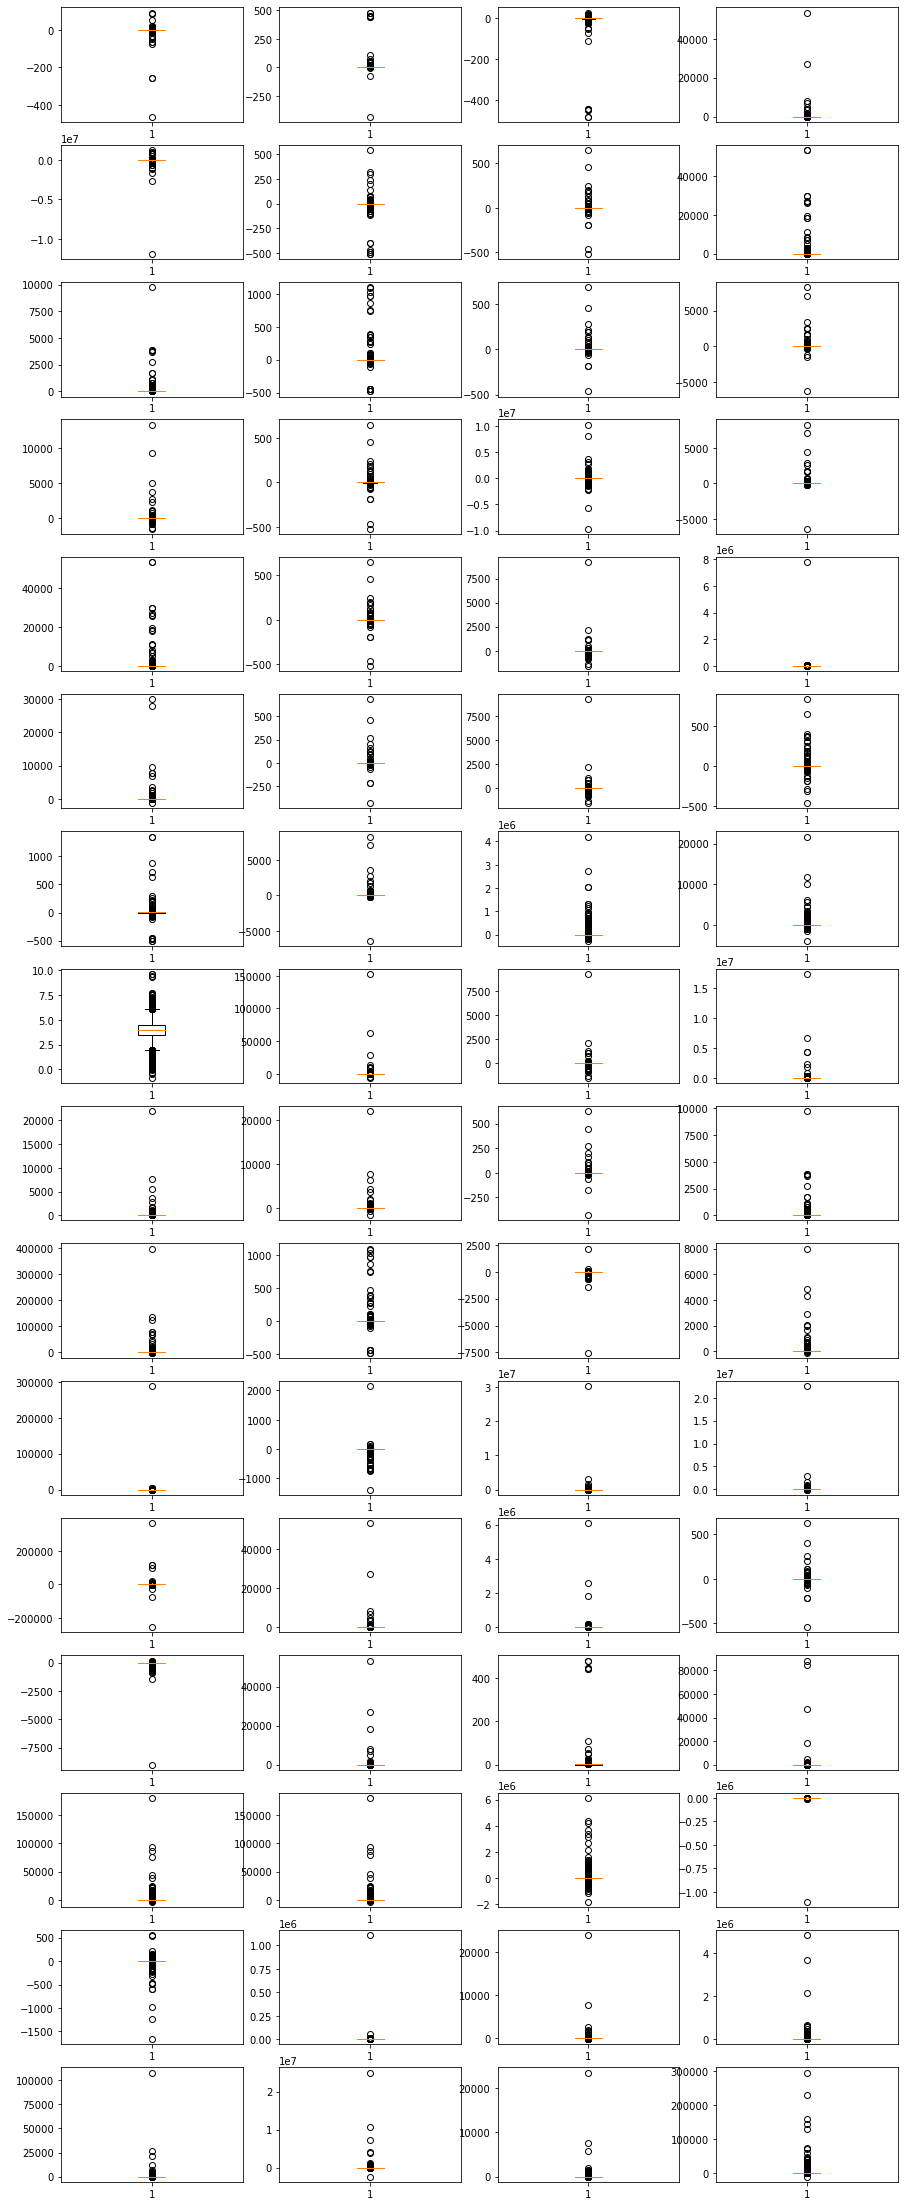

In [21]:
fig,a =  plt.subplots(16,4,figsize=(15,40))

a[0][0].boxplot(data.Attr1.dropna())
a[0][1].boxplot(data.Attr2.dropna())
a[0][2].boxplot(data.Attr3.dropna())
a[0][3].boxplot(data.Attr4.dropna())

a[1][0].boxplot(data.Attr5.dropna())
a[1][1].boxplot(data.Attr6.dropna())
a[1][2].boxplot(data.Attr7.dropna())
a[1][3].boxplot(data.Attr8.dropna())

a[2][0].boxplot(data.Attr9.dropna())
a[2][1].boxplot(data.Attr10.dropna())
a[2][2].boxplot(data.Attr11.dropna())
a[2][3].boxplot(data.Attr12.dropna())

a[3][0].boxplot(data.Attr13.dropna())
a[3][1].boxplot(data.Attr14.dropna())
a[3][2].boxplot(data.Attr15.dropna())
a[3][3].boxplot(data.Attr16.dropna())

a[4][0].boxplot(data.Attr17.dropna())
a[4][1].boxplot(data.Attr18.dropna())
a[4][2].boxplot(data.Attr19.dropna())
a[4][3].boxplot(data.Attr20.dropna())

a[5][0].boxplot(data.Attr21.dropna())
a[5][1].boxplot(data.Attr22.dropna())
a[5][2].boxplot(data.Attr23.dropna())
a[5][3].boxplot(data.Attr24.dropna())

a[6][0].boxplot(data.Attr25.dropna())
a[6][1].boxplot(data.Attr26.dropna())
a[6][2].boxplot(data.Attr27.dropna())
a[6][3].boxplot(data.Attr28.dropna())

a[7][0].boxplot(data.Attr29.dropna())
a[7][1].boxplot(data.Attr30.dropna())
a[7][2].boxplot(data.Attr31.dropna())
a[7][3].boxplot(data.Attr32.dropna())

a[8][0].boxplot(data.Attr33.dropna())
a[8][1].boxplot(data.Attr34.dropna())
a[8][2].boxplot(data.Attr35.dropna())
a[8][3].boxplot(data.Attr36.dropna())

a[9][0].boxplot(data.Attr37.dropna())
a[9][1].boxplot(data.Attr38.dropna())
a[9][2].boxplot(data.Attr39.dropna())
a[9][3].boxplot(data.Attr40.dropna())

a[10][0].boxplot(data.Attr41.dropna())
a[10][1].boxplot(data.Attr42.dropna())
a[10][2].boxplot(data.Attr43.dropna())
a[10][3].boxplot(data.Attr44.dropna())

a[11][0].boxplot(data.Attr45.dropna())
a[11][1].boxplot(data.Attr46.dropna())
a[11][2].boxplot(data.Attr47.dropna())
a[11][3].boxplot(data.Attr48.dropna())

a[12][0].boxplot(data.Attr49.dropna())
a[12][1].boxplot(data.Attr50.dropna())
a[12][2].boxplot(data.Attr51.dropna())
a[12][3].boxplot(data.Attr52.dropna())

a[13][0].boxplot(data.Attr53.dropna())
a[13][1].boxplot(data.Attr54.dropna())
a[13][2].boxplot(data.Attr55.dropna())
a[13][3].boxplot(data.Attr56.dropna())

a[14][0].boxplot(data.Attr57.dropna())
a[14][1].boxplot(data.Attr58.dropna())
a[14][2].boxplot(data.Attr59.dropna())
a[14][3].boxplot(data.Attr60.dropna())

a[15][0].boxplot(data.Attr61.dropna())
a[15][1].boxplot(data.Attr62.dropna())
a[15][2].boxplot(data.Attr63.dropna())
a[15][3].boxplot(data.Attr64.dropna())

### Outliers
- It is observed that every column has outliers.
- Ids of these outlier records are stored in outlier_id_list

In [22]:
outlier_id_list = pd.Series()
for col in data.columns.values:
    if (col != 'class') & (col != 'bankrupt_after_years'):
        outlier_id_list = outlier_id_list.append(get_outliers_Zscore(data[col]).outliers_index)

In [23]:
outlier_id_list.value_counts()

12335    19
12858    19
6293     18
5787     18
5283     18
         ..
20951     1
14804     1
26858     1
20929     1
0         1
Length: 1106, dtype: int64

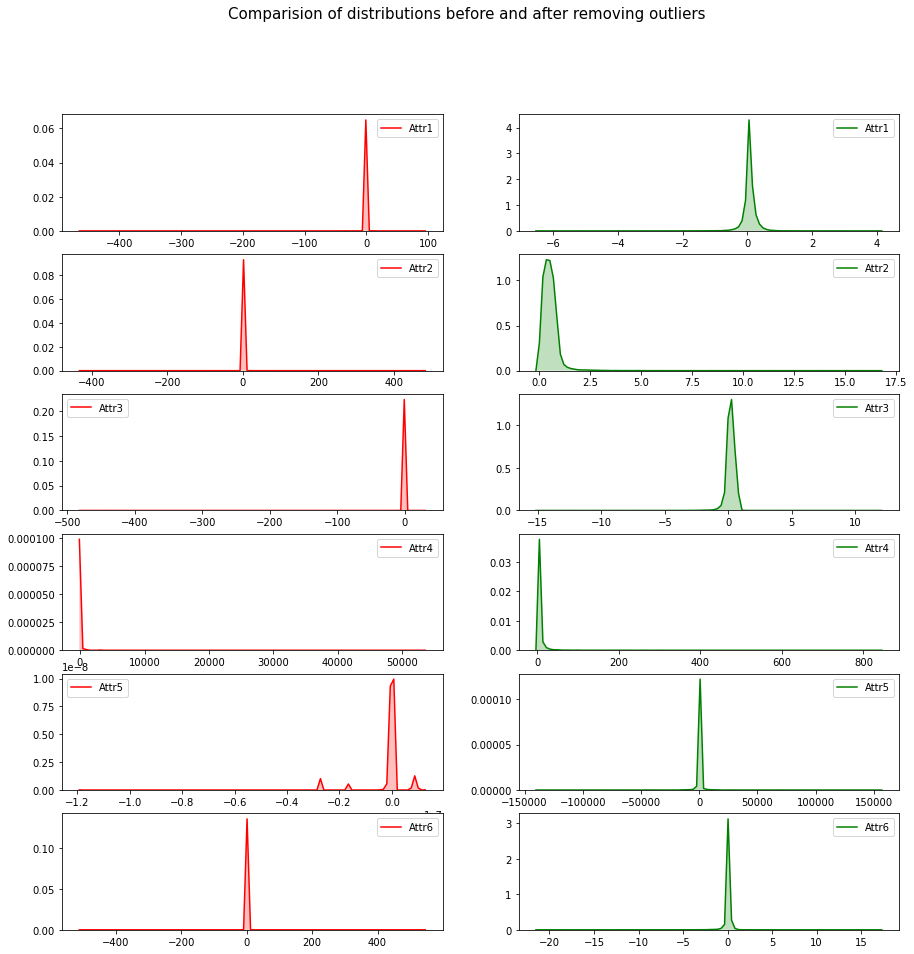

In [28]:
fig, ax = plt.subplots(6,2,figsize = (15,15))
fig.suptitle('Comparision of distributions before and after removing outliers',fontsize=15)
sns.kdeplot(data.Attr1.dropna(),color="r",shade=True,ax=ax[0][0])
sns.kdeplot(data.Attr1.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[0][1])

sns.kdeplot(data.Attr2.dropna(),color="r",shade=True,ax=ax[1][0])
sns.kdeplot(data.Attr2.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[1][1])

sns.kdeplot(data.Attr3.dropna(),color="r",shade=True,ax=ax[2][0])
sns.kdeplot(data.Attr3.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[2][1])

sns.kdeplot(data.Attr4.dropna(),color="r",shade=True,ax=ax[3][0])
sns.kdeplot(data.Attr4.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[3][1])

sns.kdeplot(data.Attr5.dropna(),color="r",shade=True,ax=ax[4][0])
sns.kdeplot(data.Attr5.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[4][1])

sns.kdeplot(data.Attr6.dropna(),color="r",shade=True,ax=ax[5][0])
sns.kdeplot(data.Attr6.drop(outlier_id_list.unique()).dropna(),color="g",shade=True,ax=ax[5][1])

plt.show()

### Observations:
- Distribution of values in each attributes are smoother after removing the outliers.
- Applying transfromations will futher normalize the distribution

In [29]:
data1 = data.copy()

In [30]:
## Attr37 is having 43.7% of missing valuee. So removing it seems to be the best approach.
data1.drop('Attr37',axis=1,inplace=True)

In [31]:
data1.drop(outlier_id_list.unique(),inplace=True)

In [32]:
data1.reset_index(drop=True,inplace=True)

In [33]:
## Different types of scaling methods are used.
mms = MinMaxScaler()
sscaler = StandardScaler()
ptransform = PowerTransformer(method='yeo-johnson')

### Missing values:
- Missing values are filled with median of the respective attributes.

In [34]:
for col in data1.columns.values:
    data1[col].fillna(data1[col].median(),inplace=True)

In [35]:
for col in data1.columns.values:
    if col != 'class': 
        data1[col] = ptransform.fit_transform(data1[col].values.reshape(-1,1))

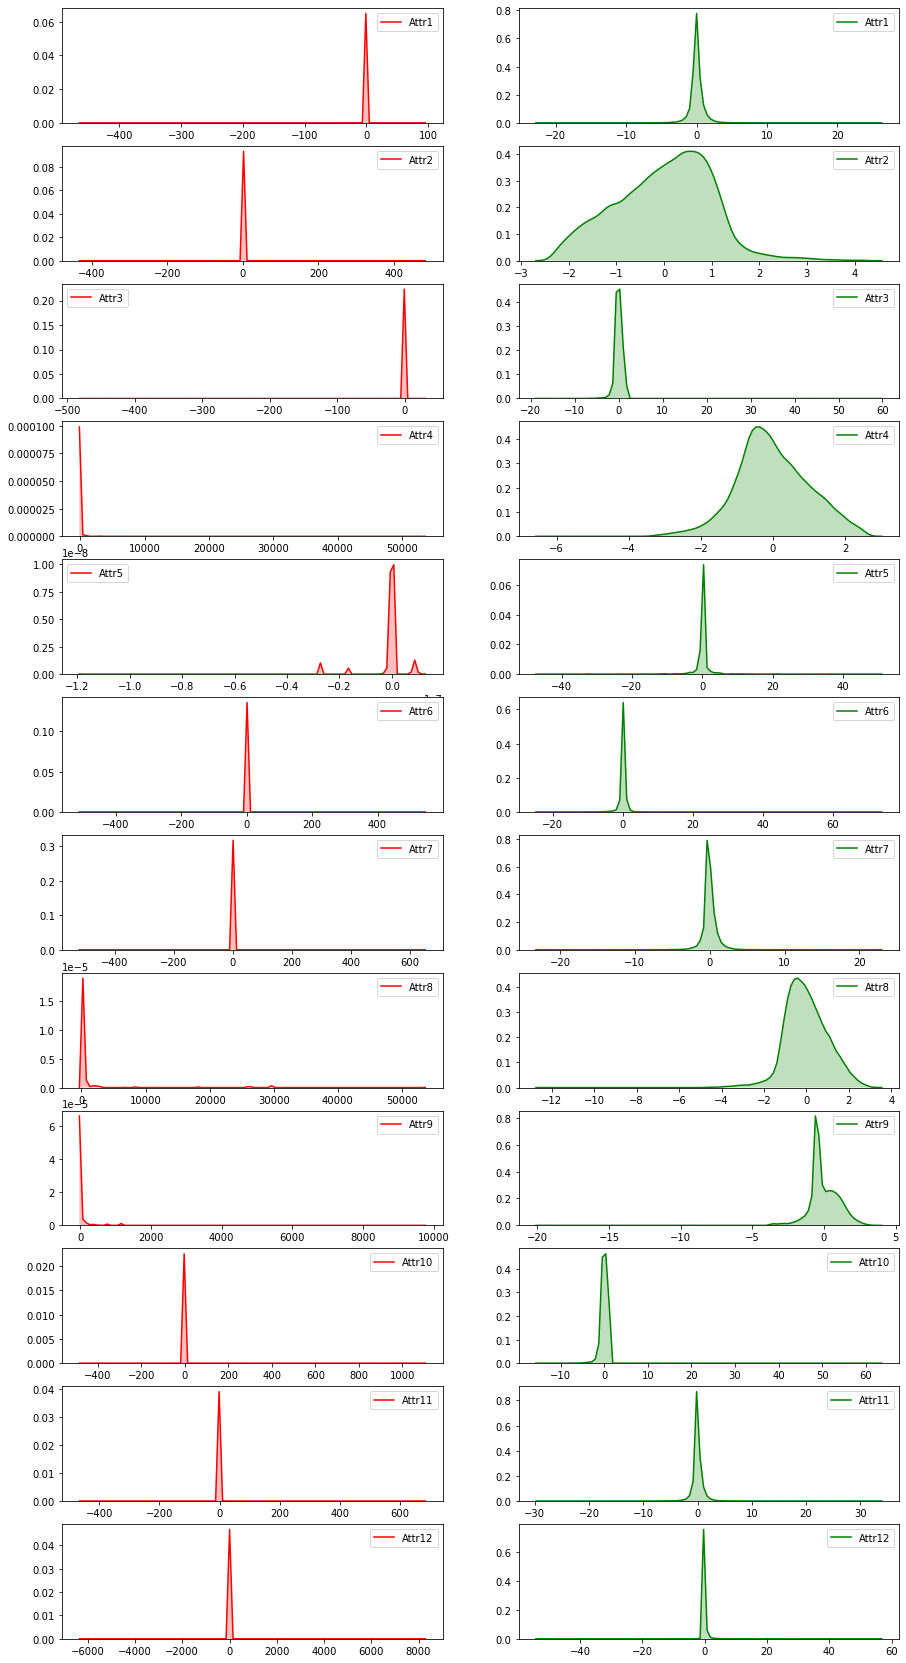

In [37]:
fig, ax = plt.subplots(12,2,figsize = (15,30))
sns.kdeplot(data.Attr1.fillna(data.Attr1.median()),color="r",shade=True,ax=ax[0][0])
sns.kdeplot(data1.Attr1,color="g",shade=True,ax=ax[0][1])

sns.kdeplot(data.Attr2.fillna(data.Attr2.median()),color="r",shade=True,ax=ax[1][0])
sns.kdeplot(data1.Attr2,color="g",shade=True,ax=ax[1][1])

sns.kdeplot(data.Attr3.fillna(data.Attr3.median()),color="r",shade=True,ax=ax[2][0])
sns.kdeplot(data1.Attr3,color="g",shade=True,ax=ax[2][1])

sns.kdeplot(data.Attr4.fillna(data.Attr4.median()),color="r",shade=True,ax=ax[3][0])
sns.kdeplot(data1.Attr4,color="g",shade=True,ax=ax[3][1])

sns.kdeplot(data.Attr5.fillna(data.Attr5.median()),color="r",shade=True,ax=ax[4][0])
sns.kdeplot(data1.Attr5,color="g",shade=True,ax=ax[4][1])

sns.kdeplot(data.Attr6.fillna(data.Attr6.median()),color="r",shade=True,ax=ax[5][0])
sns.kdeplot(data1.Attr6,color="g",shade=True,ax=ax[5][1])

sns.kdeplot(data.Attr7.fillna(data.Attr7.median()),color="r",shade=True,ax=ax[6][0])
sns.kdeplot(data1.Attr7,color="g",shade=True,ax=ax[6][1])

sns.kdeplot(data.Attr8.fillna(data.Attr8.median()),color="r",shade=True,ax=ax[7][0])
sns.kdeplot(data1.Attr8,color="g",shade=True,ax=ax[7][1])

sns.kdeplot(data.Attr9.fillna(data.Attr9.median()),color="r",shade=True,ax=ax[8][0])
sns.kdeplot(data1.Attr9,color="g",shade=True,ax=ax[8][1])

sns.kdeplot(data.Attr10.fillna(data.Attr10.median()),color="r",shade=True,ax=ax[9][0])
sns.kdeplot(data1.Attr10,color="g",shade=True,ax=ax[9][1])

sns.kdeplot(data.Attr11.fillna(data.Attr11.median()),color="r",shade=True,ax=ax[10][0])
sns.kdeplot(data1.Attr11,color="g",shade=True,ax=ax[10][1])

sns.kdeplot(data.Attr12.fillna(data.Attr12.median()),color="r",shade=True,ax=ax[11][0])
sns.kdeplot(data1.Attr12,color="g",shade=True,ax=ax[11][1])

plt.show()

In [38]:
model_df = pd.DataFrame(columns=['Model','Description','Train_F1','Test_F1','AUC'])

In [40]:
X = data1.drop(['class'],axis=1)
y = data1['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(29064, 64)
(12457, 64)
(29064,)
(12457,)


In [41]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9396126091910367
Test F1 Score: 0.6978260869565218


In [42]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
auc(fpr,tpr)

0.7746264305799805

In [60]:
df1 = {'Model':'XGBoost_Power_Transform',
         'Description':'n_estimators=250,max_depth=5, na imputed with median',
         'Train_F1':0.939,
         'Test_F1':0.697,
         'AUC':0.774}

In [61]:
model_df = model_df.append(df1,ignore_index=True)

In [53]:
xgb_model = XGBClassifier(n_estimators=300,max_depth=5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9693613879660391
Test F1 Score: 0.7005405405405406


In [54]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
auc(fpr,tpr)

0.7771151117609687

In [62]:
df1 = {'Model':'XGBoost_Power_Transform',
         'Description':'n_estimators=300,max_depth=5, na imputed with median',
         'Train_F1':0.969,
         'Test_F1':0.700,
         'AUC':0.777}
model_df = model_df.append(df1,ignore_index=True)

In [63]:
model_df

,Model,Description,Train_F1,Test_F1,AUC
0,XGBoost_Power_Transform,"n_estimators=250,max_depth=5, na imputed with ...",0.939,0.697,0.774
1,XGBoost_Power_Transform,"n_estimators=300,max_depth=5, na imputed with ...",0.969,0.700,0.777


In [64]:
params = { 'n_estimators': [200,300,400,500],
          'max_depth': [5,6,7],
          'learning_rate' : [0.1, 0.01, 0.05, 0.3]
         }

In [65]:
grid_xgb = GridSearchCV(estimator= XGBClassifier(), param_grid = params, cv=5)

In [66]:
grid_xgb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.05, 0.3],
                         'max_depth': [5, 6, 7],
                         'n_estimators': [200, 300, 400, 500]}

In [68]:
grid_xgb.best_score_

0.9789772999716206

In [69]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [70]:
grid_xgb.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}

In [71]:
y_train_preds = grid_xgb.predict(X_train)
y_test_preds = grid_xgb.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 1.0
Test F1 Score: 0.7301255230125523


In [97]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=4,learning_rate=0.3,gamma=0.1)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9964054636951833
Test F1 Score: 0.7401247401247403


In [64]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=4,learning_rate=0.3,gamma=0.5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9960445882775979
Test F1 Score: 0.740894901144641


In [65]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
auc(fpr,tpr)

0.8043909303836654

In [66]:
df1 = {'Model':'XGBoost_Power_Transform_Grid_serach',
         'Description':'n_estimators=250,max_depth=4,learning_rate=0.3,gamma=0.5, na imputed with median',
         'Train_F1':0.996,
         'Test_F1':0.740,
         'AUC':0.804}
model_df = model_df.append(df1,ignore_index=True)

In [68]:
data.drop('Attr37',axis=1,inplace=True)

data.drop(outlier_id_list.unique(),inplace=True)

data.reset_index(drop=True,inplace=True)

mms = MinMaxScaler()

for col in data.columns.values:
    data[col].fillna(data[col].median(),inplace=True)

for col in data.columns.values:
    if col != 'class': 
        data[col] = mms.fit_transform(data[col].values.reshape(-1,1))

X = data.drop(['class'],axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(29064, 64)
(12457, 64)
(29064,)
(12457,)


In [69]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=5,learning_rate=0.3, gamma=0.5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9989243456435998
Test F1 Score: 0.7468879668049793


In [70]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
auc(fpr,tpr)

0.8078635709252469

In [71]:
df1 = {'Model':'XGBoost_MinMax_Scaler',
         'Description':'n_estimators=250,max_depth=5,learning_rate=0.3,gamma=0.5, na imputed with median',
         'Train_F1':0.998,
         'Test_F1':0.746,
         'AUC':0.807}
model_df = model_df.append(df1,ignore_index=True)

In [73]:
data = pd.concat([one,two,three,four,five],ignore_index=True)

In [74]:
data.drop('Attr37',axis=1,inplace=True)

data.drop(outlier_id_list.unique(),inplace=True)

data.reset_index(drop=True,inplace=True)

sscaler = StandardScaler()

for col in data.columns.values:
    data[col].fillna(data[col].median(),inplace=True)

for col in data.columns.values:
    if col != 'class': 
        data[col] = sscaler.fit_transform(data[col].values.reshape(-1,1))

X = data.drop(['class'],axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(29064, 64)
(12457, 64)
(29064,)
(12457,)


In [75]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=5,learning_rate=0.3, gamma=0.5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.9992831541218639
Test F1 Score: 0.7164179104477613


In [76]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
auc(fpr,tpr)

0.7873645981490615

In [77]:
df1 = {'Model':'XGBoost_Standard_Scaler',
         'Description':'n_estimators=250,max_depth=5,learning_rate=0.3,gamma=0.5, na imputed with median',
         'Train_F1':0.999,
         'Test_F1':0.716,
         'AUC':0.787}
model_df = model_df.append(df1,ignore_index=True)

### Variance Inflation Factor

In [78]:
X = data1.drop(['class'],axis=1)
y = data1['class']

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [81]:
def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [82]:
X_vif = calculate_vif(X,thresh= 10)

Dropping Attr7 with vif=inf
Dropping Attr14 with vif=inf
Dropping Attr17 with vif=219.17335699789558
Dropping Attr16 with vif=159.08333344549962
Dropping Attr19 with vif=137.9110977515024
Dropping Attr2 with vif=97.63552896192395
Dropping Attr54 with vif=52.31428130055102
Dropping Attr18 with vif=41.95902089273517
Dropping Attr8 with vif=33.01117013885787
Dropping Attr13 with vif=31.046453711181865
Dropping Attr43 with vif=28.273200671325107
Dropping Attr63 with vif=21.540450984520366
Dropping Attr4 with vif=19.47660181303697
Dropping Attr23 with vif=17.55273104628124
Dropping Attr22 with vif=15.37040289342288
Dropping Attr46 with vif=14.318403167124785
Dropping Attr10 with vif=12.967090066706486
Dropping Attr42 with vif=11.122586440830458


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_vif,y, train_size = 0.7,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(29064, 46)
(12457, 46)
(29064,)
(12457,)


In [84]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
print('Test AUC:', auc(fpr,tpr))

Train F1 Score: 0.5313807531380753
Test F1 Score: 0.4742268041237113
Test AUC: 0.6574254804087862


In [85]:
df1 = {'Model':'XGBoost_VIF_Power_Transform',
         'Description':'Base, na imputed with median',
         'Train_F1':0.531,
         'Test_F1':0.474,
         'AUC':0.657}
model_df = model_df.append(df1,ignore_index=True)

In [86]:
xgb_model = XGBClassifier(max_depth=5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
print('Test AUC:', auc(fpr,tpr))

Train F1 Score: 0.7142199723884031
Test F1 Score: 0.6037735849056605
Test AUC: 0.7191750515923198


In [87]:
df1 = {'Model':'XGBoost_VIF_Power_Transform',
         'Description':'max_depth = 5, na imputed with median',
         'Train_F1':0.714,
         'Test_F1':0.603,
         'AUC':0.719}
model_df = model_df.append(df1,ignore_index=True)

In [88]:
xgb_model = XGBClassifier(max_depth=5,learning_rate=0.3)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
print('Test AUC:', auc(fpr,tpr))

Train F1 Score: 0.9261538461538462
Test F1 Score: 0.6615886833514689
Test AUC: 0.7593729297705958


In [89]:
df1 = {'Model':'XGBoost_VIF_Power_Transform',
         'Description':'max_depth = 5,learning_rate = 0.3, na imputed with median',
         'Train_F1':0.926,
         'Test_F1':0.661,
         'AUC':0.7593}
model_df = model_df.append(df1,ignore_index=True)

In [95]:
xgb_model = XGBClassifier(n_estimators=250,max_depth=5,learning_rate=0.3, gamma=0.5)
xgb_model.fit(X_train,y_train)

y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)
print('Test AUC:', auc(fpr,tpr))

Train F1 Score: 0.9989243456435998
Test F1 Score: 0.6478260869565218
Test AUC: 0.7539323705078279


In [92]:
model_df

,Model,Description,Train_F1,Test_F1,AUC
0,XGBoost_Power_Transform,"n_estimators=250,max_depth=5, na imputed with ...",0.939,0.697,0.7740
1,XGBoost_Power_Transform,"n_estimators=300,max_depth=5, na imputed with ...",0.969,0.700,0.7770
2,XGBoost_Power_Transform_Grid_serach,"n_estimators=250,max_depth=4,learning_rate=0.3...",0.996,0.740,0.8040
3,XGBoost_MinMax_Scaler,"n_estimators=250,max_depth=5,learning_rate=0.3...",0.998,0.746,0.8070
4,XGBoost_Standard_Scaler,"n_estimators=250,max_depth=5,learning_rate=0.3...",0.999,0.716,0.7870
5,XGBoost_VIF_Power_Transform,"Base, na imputed with median",0.531,0.474,0.6570
6,XGBoost_VIF_Power_Transform,"max_depth = 5, na imputed with median",0.714,0.603,0.7190
7,XGBoost_VIF_Power_Transform,"max_depth = 5,learning_rate = 0.3, na imputed ...",0.926,0.661,0.7593


In [96]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential

Using TensorFlow backend.


In [97]:
from keras import backend as K

def Recall_score(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def Precision_score(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def F1_score(y_true, y_pred):
    precision = Precision_score(y_true, y_pred)
    recall = Recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
X = data1.drop(['class'],axis=1)
y = data1['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(29064, 64)
(12457, 64)
(29064,)
(12457,)


In [186]:
model = Sequential()
model.add(Dense(100, input_dim=64, activation='tanh',kernel_initializer='normal'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='tanh',kernel_initializer='normal'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='tanh',kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=[F1_score],)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 12,383
Trainable params: 12,383
Non-trainable params: 0
_________________________________________________

In [187]:
h = model.fit(X_train, y_train, epochs=1000, batch_size=64,validation_split=0.2)

Train on 23251 samples, validate on 5813 samples
Epoch 1/1000
23251/23251 [==============================] - 1s 54us/step - loss: 0.2188 - F1_score: 0.0446 - val_loss: 0.1751 - val_F1_score: 0.0469
Epoch 2/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.1767 - F1_score: 0.0277 - val_loss: 0.1737 - val_F1_score: 0.0420
Epoch 3/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.1727 - F1_score: 0.0425 - val_loss: 0.1794 - val_F1_score: 0.0037
Epoch 4/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.1698 - F1_score: 0.0392 - val_loss: 0.1667 - val_F1_score: 0.0428
Epoch 5/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.1659 - F1_score: 0.0536 - val_loss: 0.1623 - val_F1_score: 0.0952
Epoch 6/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.1594 - F1_score: 0.1065 - val_loss: 0.1552 - val_F1_score: 0.1260
Epoch 7/1000
23251/23251 [==============================]

23251/23251 [==============================] - 1s 31us/step - loss: 0.0835 - F1_score: 0.5793 - val_loss: 0.0883 - val_F1_score: 0.5680
Epoch 110/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0821 - F1_score: 0.5732 - val_loss: 0.0944 - val_F1_score: 0.4950
Epoch 111/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0831 - F1_score: 0.5514 - val_loss: 0.0904 - val_F1_score: 0.5762
Epoch 112/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0804 - F1_score: 0.5861 - val_loss: 0.0928 - val_F1_score: 0.5303
Epoch 113/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0831 - F1_score: 0.5594 - val_loss: 0.0870 - val_F1_score: 0.5692
Epoch 114/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0814 - F1_score: 0.5836 - val_loss: 0.0869 - val_F1_score: 0.5381
Epoch 115/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0801 - F1_score: 0.5872 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0709 - F1_score: 0.6554 - val_loss: 0.0876 - val_F1_score: 0.5479
Epoch 218/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0698 - F1_score: 0.6528 - val_loss: 0.0843 - val_F1_score: 0.5932
Epoch 219/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0738 - F1_score: 0.6277 - val_loss: 0.0883 - val_F1_score: 0.5704
Epoch 220/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0725 - F1_score: 0.6205 - val_loss: 0.0853 - val_F1_score: 0.5936
Epoch 221/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0735 - F1_score: 0.6311 - val_loss: 0.0878 - val_F1_score: 0.5544
Epoch 222/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0709 - F1_score: 0.6376 - val_loss: 0.0878 - val_F1_score: 0.5740
Epoch 223/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0714 - F1_score: 0.6435 

23251/23251 [==============================] - 1s 34us/step - loss: 0.0648 - F1_score: 0.6633 - val_loss: 0.0849 - val_F1_score: 0.5828
Epoch 326/1000
23251/23251 [==============================] - 1s 34us/step - loss: 0.0644 - F1_score: 0.6875 - val_loss: 0.0832 - val_F1_score: 0.6141
Epoch 327/1000
23251/23251 [==============================] - 1s 33us/step - loss: 0.0650 - F1_score: 0.6961 - val_loss: 0.0875 - val_F1_score: 0.5928
Epoch 328/1000
23251/23251 [==============================] - 1s 33us/step - loss: 0.0636 - F1_score: 0.6904 - val_loss: 0.0842 - val_F1_score: 0.6264
Epoch 329/1000
23251/23251 [==============================] - 1s 34us/step - loss: 0.0641 - F1_score: 0.6876 - val_loss: 0.0884 - val_F1_score: 0.5792
Epoch 330/1000
23251/23251 [==============================] - 1s 34us/step - loss: 0.0657 - F1_score: 0.6759 - val_loss: 0.0841 - val_F1_score: 0.6097
Epoch 331/1000
23251/23251 [==============================] - 1s 34us/step - loss: 0.0643 - F1_score: 0.6731 

23251/23251 [==============================] - 1s 32us/step - loss: 0.0625 - F1_score: 0.6806 - val_loss: 0.0906 - val_F1_score: 0.6093
Epoch 434/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0597 - F1_score: 0.7116 - val_loss: 0.0881 - val_F1_score: 0.6089
Epoch 435/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0601 - F1_score: 0.6922 - val_loss: 0.0892 - val_F1_score: 0.5810
Epoch 436/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0609 - F1_score: 0.7166 - val_loss: 0.0885 - val_F1_score: 0.5953
Epoch 437/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0614 - F1_score: 0.6965 - val_loss: 0.0932 - val_F1_score: 0.5772
Epoch 438/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0607 - F1_score: 0.7188 - val_loss: 0.0918 - val_F1_score: 0.5954
Epoch 439/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0605 - F1_score: 0.6850 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0584 - F1_score: 0.7281 - val_loss: 0.0907 - val_F1_score: 0.5907
Epoch 542/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0578 - F1_score: 0.7174 - val_loss: 0.0902 - val_F1_score: 0.5990
Epoch 543/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0581 - F1_score: 0.7083 - val_loss: 0.0925 - val_F1_score: 0.5976
Epoch 544/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0581 - F1_score: 0.7059 - val_loss: 0.0910 - val_F1_score: 0.5793
Epoch 545/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0576 - F1_score: 0.7290 - val_loss: 0.0923 - val_F1_score: 0.5650
Epoch 546/1000
23251/23251 [==============================] - 1s 33us/step - loss: 0.0551 - F1_score: 0.7080 - val_loss: 0.0862 - val_F1_score: 0.6001
Epoch 547/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0560 - F1_score: 0.7152 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0546 - F1_score: 0.7324 - val_loss: 0.0867 - val_F1_score: 0.6162
Epoch 650/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0544 - F1_score: 0.7108 - val_loss: 0.0886 - val_F1_score: 0.6238
Epoch 651/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0556 - F1_score: 0.7280 - val_loss: 0.0875 - val_F1_score: 0.6205
Epoch 652/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0564 - F1_score: 0.7080 - val_loss: 0.0918 - val_F1_score: 0.6003
Epoch 653/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0545 - F1_score: 0.7163 - val_loss: 0.0903 - val_F1_score: 0.6210
Epoch 654/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0562 - F1_score: 0.7180 - val_loss: 0.0887 - val_F1_score: 0.6023
Epoch 655/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0558 - F1_score: 0.7313 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0523 - F1_score: 0.7362 - val_loss: 0.0996 - val_F1_score: 0.5779
Epoch 758/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0533 - F1_score: 0.7455 - val_loss: 0.0935 - val_F1_score: 0.6006
Epoch 759/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0534 - F1_score: 0.7403 - val_loss: 0.0902 - val_F1_score: 0.5858
Epoch 760/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0556 - F1_score: 0.7329 - val_loss: 0.0999 - val_F1_score: 0.6029
Epoch 761/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0514 - F1_score: 0.7440 - val_loss: 0.0919 - val_F1_score: 0.6207
Epoch 762/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0543 - F1_score: 0.7394 - val_loss: 0.0949 - val_F1_score: 0.5914
Epoch 763/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0537 - F1_score: 0.7140 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0511 - F1_score: 0.7631 - val_loss: 0.0951 - val_F1_score: 0.5991
Epoch 866/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0520 - F1_score: 0.7555 - val_loss: 0.0955 - val_F1_score: 0.5897
Epoch 867/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0525 - F1_score: 0.7486 - val_loss: 0.0965 - val_F1_score: 0.5943
Epoch 868/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0534 - F1_score: 0.7228 - val_loss: 0.0946 - val_F1_score: 0.5984
Epoch 869/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0527 - F1_score: 0.7260 - val_loss: 0.0930 - val_F1_score: 0.5993
Epoch 870/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0550 - F1_score: 0.7194 - val_loss: 0.0925 - val_F1_score: 0.6255
Epoch 871/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0535 - F1_score: 0.7416 

23251/23251 [==============================] - 1s 31us/step - loss: 0.0482 - F1_score: 0.7457 - val_loss: 0.0901 - val_F1_score: 0.6129
Epoch 974/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0496 - F1_score: 0.7627 - val_loss: 0.0914 - val_F1_score: 0.6129
Epoch 975/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0497 - F1_score: 0.7529 - val_loss: 0.0957 - val_F1_score: 0.5946
Epoch 976/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0500 - F1_score: 0.7376 - val_loss: 0.0917 - val_F1_score: 0.6052
Epoch 977/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0505 - F1_score: 0.7373 - val_loss: 0.0940 - val_F1_score: 0.6113
Epoch 978/1000
23251/23251 [==============================] - 1s 32us/step - loss: 0.0521 - F1_score: 0.7424 - val_loss: 0.0927 - val_F1_score: 0.6055
Epoch 979/1000
23251/23251 [==============================] - 1s 31us/step - loss: 0.0501 - F1_score: 0.7418 

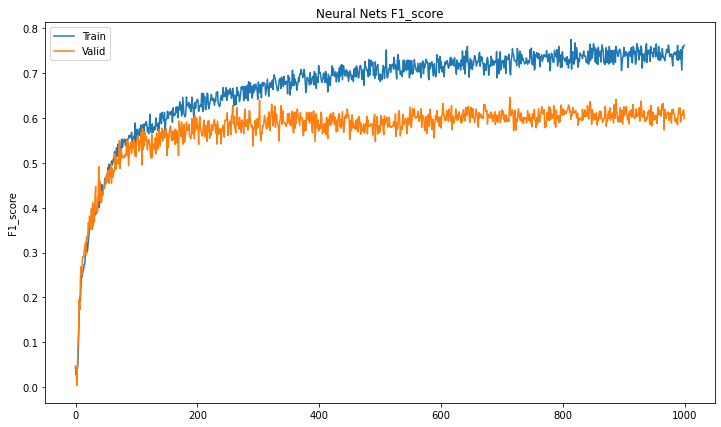

In [188]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(12)
ax.plot(h.history['F1_score'], label='Train')
ax.plot(h.history['val_F1_score'], label='Valid')
ax.legend()
plt.ylabel('F1_score')
plt.title('Neural Nets F1_score')
plt.show()

In [189]:
y_train_preds = model.predict_classes(X_train).ravel()
y_test_preds = model.predict_classes(X_test).ravel()

print('Train F1 Score:', f1_score(y_train,y_train_preds))
print('Test F1 Score:', f1_score(y_test,y_test_preds))

Train F1 Score: 0.8760139049826188
Test F1 Score: 0.7148437499999999


In [195]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_preds)

auc(fpr,tpr)

0.8107354928290793

In [100]:
df1 = {'Model':'Neural Net',
         'Description':"(Dense(100, input_dim=64, activation='tanh',kernel_initializer='normal'))(Dropout(0.3))Dense(50, activation='tanh',kernel_initializer='normal'))(Dropout(0.1))(Dense(16, activation='tanh',kernel_initializer='normal'))(Dense(1, activation='sigmoid'))compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=[F1_score]) epochs=1000, batch_size=64,validation_split=0.2",
         'Train_F1':0.876,
         'Test_F1':0.714,
         'AUC':0.810}
model_df = model_df.append(df1,ignore_index=True)

In [102]:
model_df

,Model,Description,Train_F1,Test_F1,AUC
0,XGBoost_Power_Transform,"n_estimators=250,max_depth=5, na imputed with ...",0.939,0.697,0.7740
1,XGBoost_Power_Transform,"n_estimators=300,max_depth=5, na imputed with ...",0.969,0.700,0.7770
2,XGBoost_Power_Transform_Grid_serach,"n_estimators=250,max_depth=4,learning_rate=0.3...",0.996,0.740,0.8040
3,XGBoost_MinMax_Scaler,"n_estimators=250,max_depth=5,learning_rate=0.3...",0.998,0.746,0.8070
4,XGBoost_Standard_Scaler,"n_estimators=250,max_depth=5,learning_rate=0.3...",0.999,0.716,0.7870
5,XGBoost_VIF_Power_Transform,"Base, na imputed with median",0.531,0.474,0.6570
6,XGBoost_VIF_Power_Transform,"max_depth = 5, na imputed with median",0.714,0.603,0.7190
7,XGBoost_VIF_Power_Transform,"max_depth = 5,learning_rate = 0.3, na imputed ...",0.926,0.661,0.7593
8,Neural Net,"(Dense(100, input_dim=64, activation='tanh',ke...",0.876,0.714,0.8100
